# Jacobian Norm Analysis & Visualization

이 노트북은 Memorized Prompt에 대해 Input Embedding (IE) 및 Text Embedding (TE)에 대한 Jacobian Norm을 계산합니다.

**목표:**
1. Memorized Prompt 100개에 대해 $t=T$ (초기 시점)에서의 Jacobian Norm (IE, TE) 계산
2. Norm 크기에 따라 Prompt 정렬 및 상위/하위 5개 추출
3. 특정 Prompt에 대해 Embedding에 Gaussian Noise를 추가하여 샘플링 후 시각화


In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from local_sd_pipeline import LocalStableDiffusionPipeline
from diffusers import DDIMScheduler

# Configuration
MODEL_ID = "CompVis/stable-diffusion-v1-4"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
NUM_PROMPTS = 100
NUM_STEPS = 50

torch.manual_seed(SEED)
np.random.seed(SEED)

print(f"Device: {DEVICE}")

Device: cuda


In [ ]:
# Load Pipeline
pipeline = LocalStableDiffusionPipeline.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float32,
    requires_safety_checker=False
).to(DEVICE)
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
pipeline.set_progress_bar_config(disable=True)

/home/gpuadmin/cssin/init_noise_diffusion_memorization/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# Load Prompts
try:
    df = pd.read_csv('prompts/memorized_laion_prompts.csv', sep=';')
    memorized_prompts = df['Caption'].tolist()[:NUM_PROMPTS]
    print(f"Loaded {len(memorized_prompts)} memorized prompts.")
except Exception as e:
    print(f"Error loading prompts: {e}")
    memorized_prompts = ["A sample memorized prompt for testing."] * 5

Loaded 100 memorized prompts.


## 1. Jacobian Norm Calculation Functions

In [ ]:
def compute_jacobian_norm_TE(unet, latents, t, prompt_embeds, num_projections=1):
    """
    Calculate Jacobian Norm w.r.t Text Embedding (CLIP Output)
    """
    prompt_embeds = prompt_embeds.detach()
    
    with torch.enable_grad():
        prompt_embeds.requires_grad_(True)
        total_sq_norm = 0.0
        
        for _ in range(num_projections):
            noise_pred = unet(latents, t, encoder_hidden_states=prompt_embeds).sample
            
            v = torch.randn_like(noise_pred)
            v_dot_eps = torch.sum(noise_pred * v)
            
            grads = torch.autograd.grad(v_dot_eps, prompt_embeds, create_graph=False)[0]
            total_sq_norm += torch.sum(grads ** 2).item()
            
    return np.sqrt(total_sq_norm / num_projections)

def get_input_embeddings(pipeline, prompt, device):
    """Get Input Token Embeddings"""
    text_inputs = pipeline.tokenizer(
        prompt,
        padding="max_length",
        max_length=pipeline.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    input_ids = text_inputs.input_ids.to(device)
    input_embeddings = pipeline.text_encoder.text_model.embeddings.token_embedding(input_ids)
    return input_ids, input_embeddings

def compute_jacobian_norm_IE(pipeline, latents, t, input_embeddings, input_ids, num_projections=1):
    """
    Calculate Jacobian Norm w.r.t Input Embedding (CLIP Input)
    """
    input_embeddings = input_embeddings.detach()
    
    with torch.enable_grad():
        input_embeddings.requires_grad_(True)
        total_sq_norm = 0.0
        
        for _ in range(num_projections):
            # Manual Forward Pass through CLIP Text Encoder
            # 1. Embeddings (Word + Position)
            text_model = pipeline.text_encoder.text_model
            seq_len = input_ids.shape[1]
            position_ids = text_model.embeddings.position_ids[:, :seq_len]
            hidden_states = text_model.embeddings(inputs_embeds=input_embeddings, position_ids=position_ids)
            
            # 2. Causal Mask
            bsz = input_ids.shape[0]
            # Standard causal mask for CLIP (triangular)
            mask = torch.full((bsz, 1, seq_len, seq_len), float("-inf"), device=hidden_states.device, dtype=hidden_states.dtype)
            mask = torch.triu(mask, diagonal=1)
            
            # 3. Encoder
            encoder_outputs = text_model.encoder(
                hidden_states,
                attention_mask=None,
                causal_attention_mask=mask 
            )
            
            # 4. Final Layer Norm
            last_hidden_state = text_model.final_layer_norm(encoder_outputs[0])
            
            prompt_embeds = last_hidden_state
            
            # 2. UNet Forward
            noise_pred = pipeline.unet(latents, t, encoder_hidden_states=prompt_embeds).sample
            
            # 3. Projection & Grad
            v = torch.randn_like(noise_pred)
            v_dot_eps = torch.sum(noise_pred * v)
            
            grads = torch.autograd.grad(v_dot_eps, input_embeddings, create_graph=False)[0]
            total_sq_norm += torch.sum(grads ** 2).item()
            
    return np.sqrt(total_sq_norm / num_projections)

## 2. Compute Jacobian Norms for Prompts

In [ ]:
pipeline.scheduler.set_timesteps(NUM_STEPS)
timesteps = pipeline.scheduler.timesteps
target_t = timesteps[0] # xT (Start of sampling)

# Fix Latents for consistent comparison
latents = torch.randn(
    (1, pipeline.unet.config.in_channels, 64, 64),
    device=DEVICE,
    generator=torch.Generator(device=DEVICE).manual_seed(SEED)
)
latent_input = pipeline.scheduler.scale_model_input(latents, target_t)

results = []

print("Calculating Jacobian Norms...")
for prompt in tqdm(memorized_prompts):
    # 1. Text Embedding Jacobian
    te_embeds = pipeline._encode_prompt(prompt, DEVICE, 1, False, None)
    norm_te = compute_jacobian_norm_TE(pipeline.unet, latent_input, target_t, te_embeds)
    
    # 2. Input Embedding Jacobian
    input_ids, ie_embeds = get_input_embeddings(pipeline, prompt, DEVICE)
    norm_ie = compute_jacobian_norm_IE(pipeline, latent_input, target_t, ie_embeds, input_ids)
    
    results.append({
        "Prompt": prompt,
        "J_Norm_TE": norm_te,
        "J_Norm_IE": norm_ie
    })

df_results = pd.DataFrame(results)

Calculating Jacobian Norms...


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# Analyze Results
print("Top 5 prompts by Input Embedding Jacobian Norm:")
top5_ie = df_results.sort_values("J_Norm_IE", ascending=False).head(5)
print(top5_ie[["Prompt", "J_Norm_IE"]])

print("\nBottom 5 prompts by Input Embedding Jacobian Norm:")
bot5_ie = df_results.sort_values("J_Norm_IE", ascending=True).head(5)
print(bot5_ie[["Prompt", "J_Norm_IE"]])

# Save sorted lists
df_results.sort_values("J_Norm_IE", ascending=False).to_csv("jacobian_norm_sorted_IE.csv", index=False)
df_results.sort_values("J_Norm_TE", ascending=False).to_csv("jacobian_norm_sorted_TE.csv", index=False)

Top 5 prompts by Input Embedding Jacobian Norm:
                                               Prompt    J_Norm_IE
93  Freddy Adu Signs For Yet Another Club You Prob...  1521.874502
13  Here's What You Need to Know About St. Vincent...   767.146906
26             Renegade RSS Laptop Backpack - View 91   649.742208
58  Director Danny Boyle Is Headed To TV With FX Deal   646.278239
36  J Dilla's Synthesizers, Equipment Donated to S...   577.166570

Bottom 5 prompts by Input Embedding Jacobian Norm:
                                               Prompt  J_Norm_IE
50  Designart Canada White Stained Glass Floral De...  60.321283
2                Mothers influence on her young hippo  68.712031
81  Design Art Light in Dense Fall Forest with Fog...  69.590473
0                The No Limits Business Woman Podcast  78.287232
15                                The Happy Scientist  79.397275


## 3. Visualization with Gaussian Noise Injection

특정 Prompt를 선택하여, Embedding에 Gaussian Noise를 추가한 후 생성 결과를 비교합니다.

In [ ]:
def visualize_noise_injection(pipeline, prompt, noise_scale=0.1, n_samples=4, seed=42):
    """
    Compare Noise Injection:
    1. IE -> CLIP -> TE + Noise -> UNet (Original IE request, but noise added in TE space)
    2. TE Direct (Standard)
    """
    gen = torch.Generator(device=DEVICE).manual_seed(seed)
    
    # 0. Original Image (Clean)
    print(f"Generating original sample...")
    orig_embeds = pipeline._encode_prompt(prompt, DEVICE, 1, False, None)
    gen.manual_seed(seed)
    orig_img = pipeline(prompt_embeds=orig_embeds, num_inference_steps=200, generator=gen, output_type="pil").images[0]
    
    print(f"Generating samples with TE direct noise (scale={noise_scale})...")
    base_te = pipeline._encode_prompt(prompt, DEVICE, 1, False, None)
    images_te = [orig_img]
    
    for _ in range(n_samples):
        gen.manual_seed(seed)
        noise = torch.randn_like(base_te) * noise_scale
        noisy_te = base_te + noise
        img = pipeline(prompt_embeds=noisy_te, num_inference_steps=50, generator=gen, output_type="pil").images[0]
        images_te.append(img)
        
    # Visualize
    total_cols = n_samples + 1
    fig, axes = plt.subplots(1, total_cols, figsize=(total_cols * 4, 8))


    # Row 2: TE Direct
    axes[0].set_ylabel("TE Direct Noise", fontsize=12)
    axes[0].imshow(images_te[0])
    axes[0].axis('off')
    axes[0].set_title("Original")
    for i in range(1, total_cols):
        axes[i].imshow(images_te[i])
        axes[i].axis('off')
        axes[i].set_title(f"Direct Sample {i}")
        
    plt.suptitle(f"Comparison of IE-derived TE Noise vs standard TE Noise: '{prompt}' (Scale={noise_scale})", fontsize=16)
    plt.tight_layout()
    plt.show()

Visualizing for high-sensitivity prompt: Freddy Adu Signs For Yet Another Club You Probably Don't Know
Generating original sample...
Generating samples with TE direct noise (scale=0.1)...


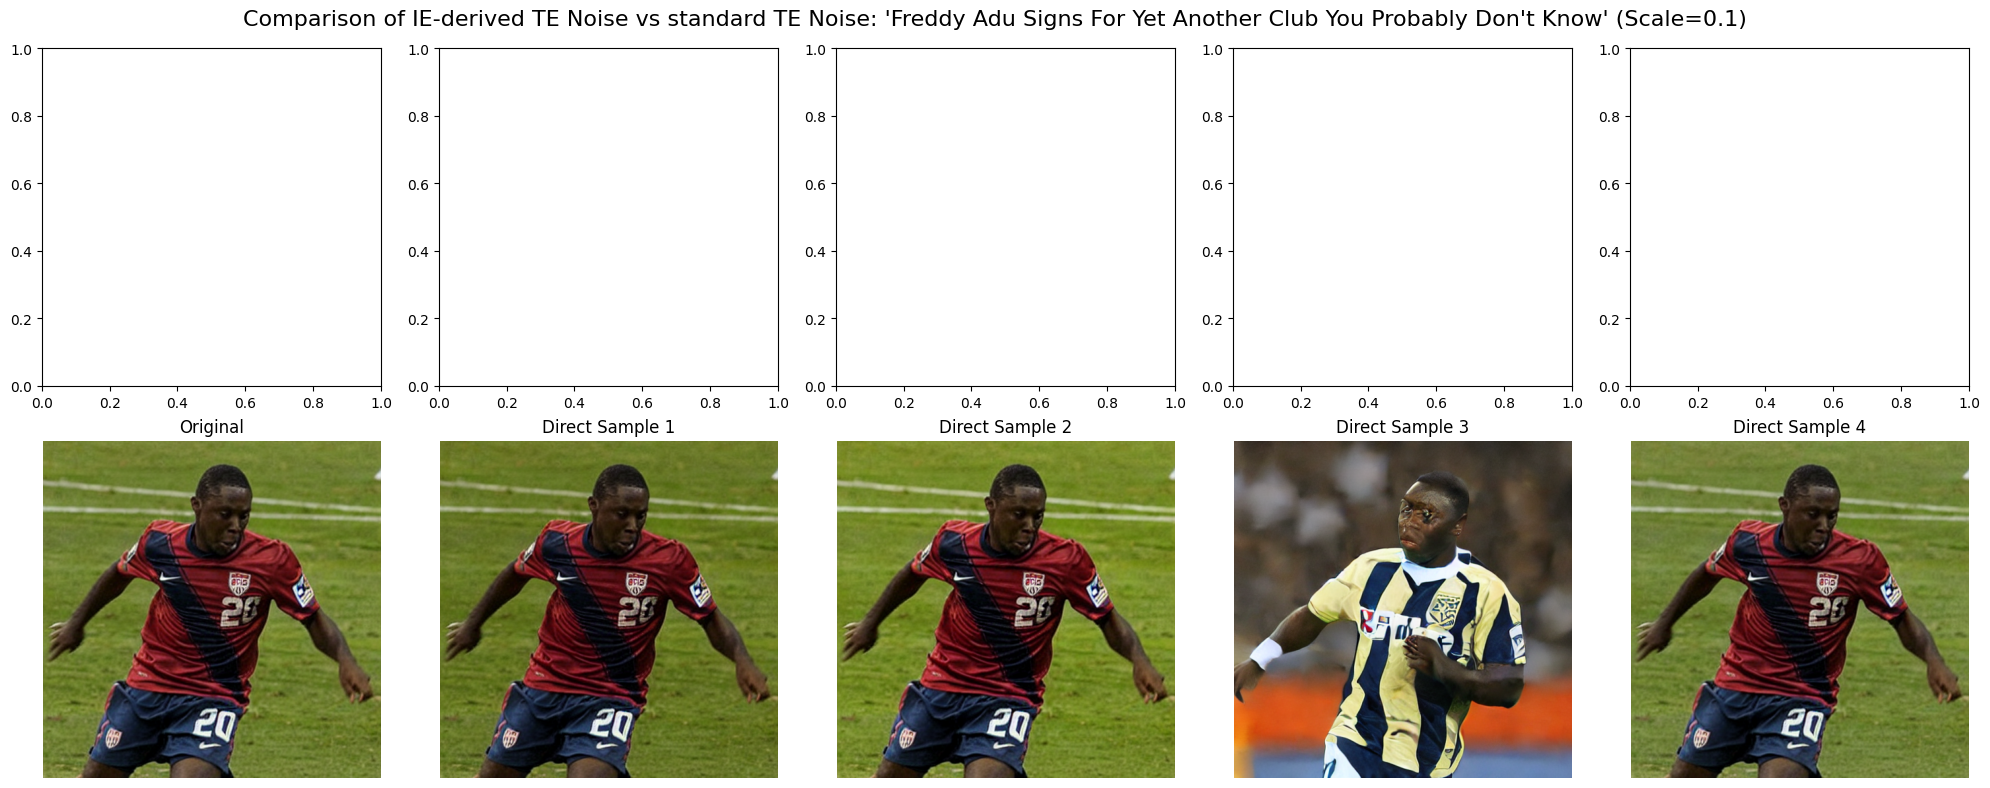

Visualizing for low-sensitivity prompt: Designart Canada White Stained Glass Floral Design 29-in Round Metal Wall Art
Generating original sample...
Generating samples with TE direct noise (scale=0.1)...


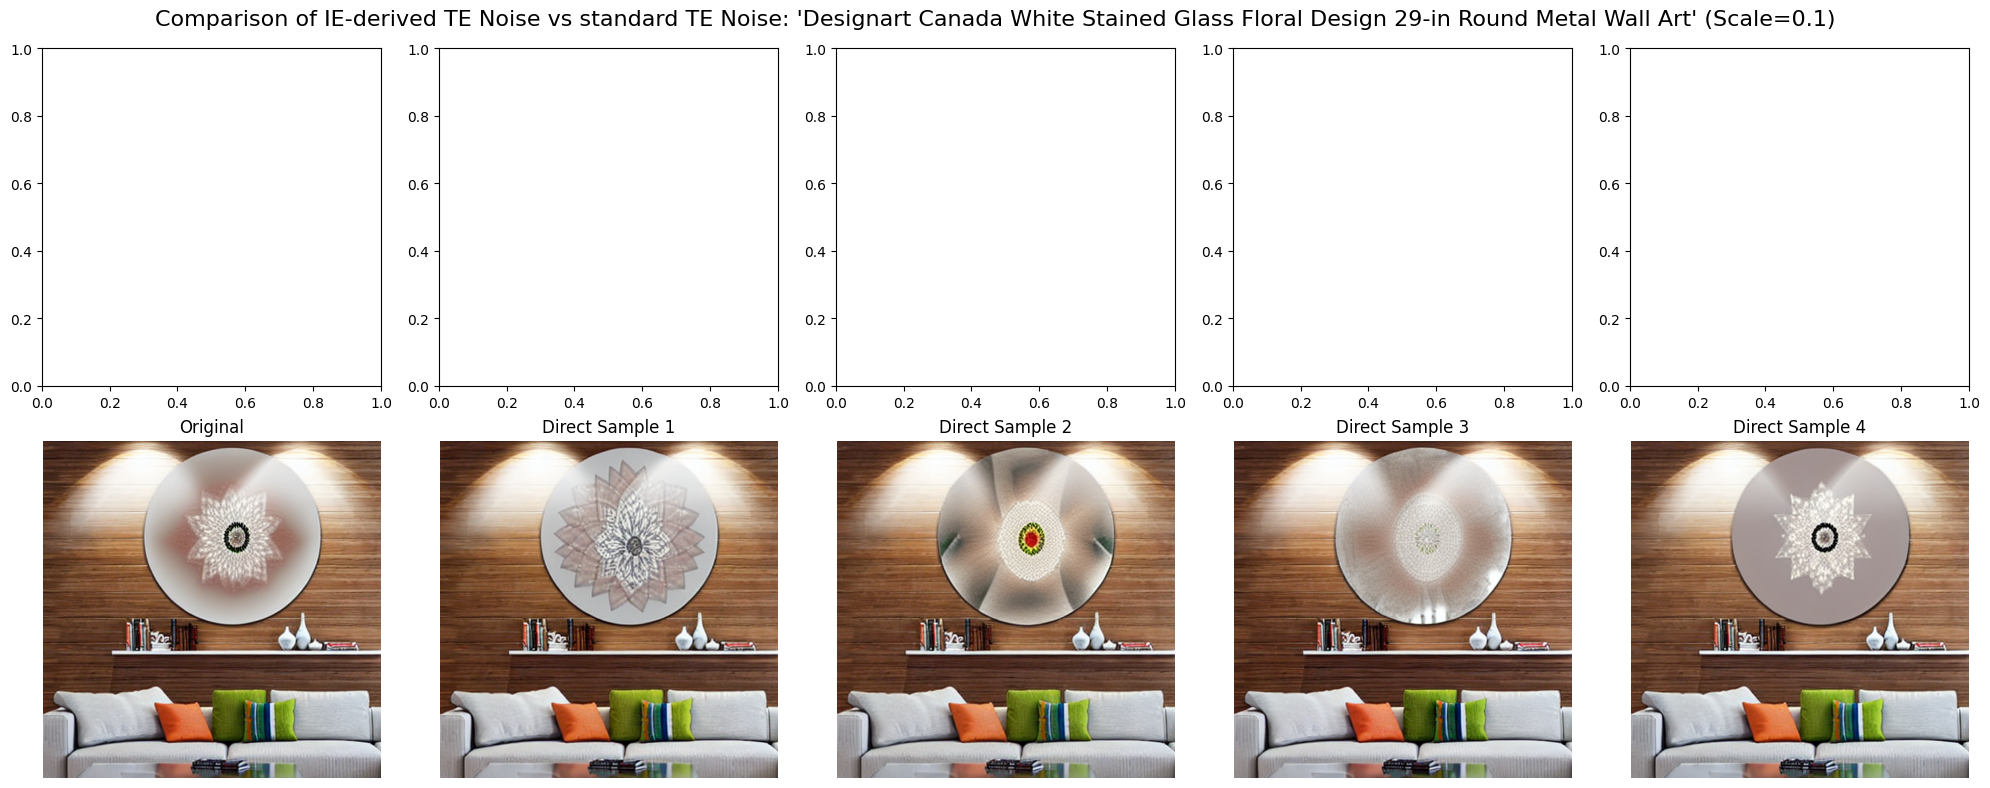

Visualizing for high-sensitivity prompt: Here's What You Need to Know About St. Vincent's Apple Music Radio Show
Generating original sample...
Generating samples with TE direct noise (scale=0.1)...


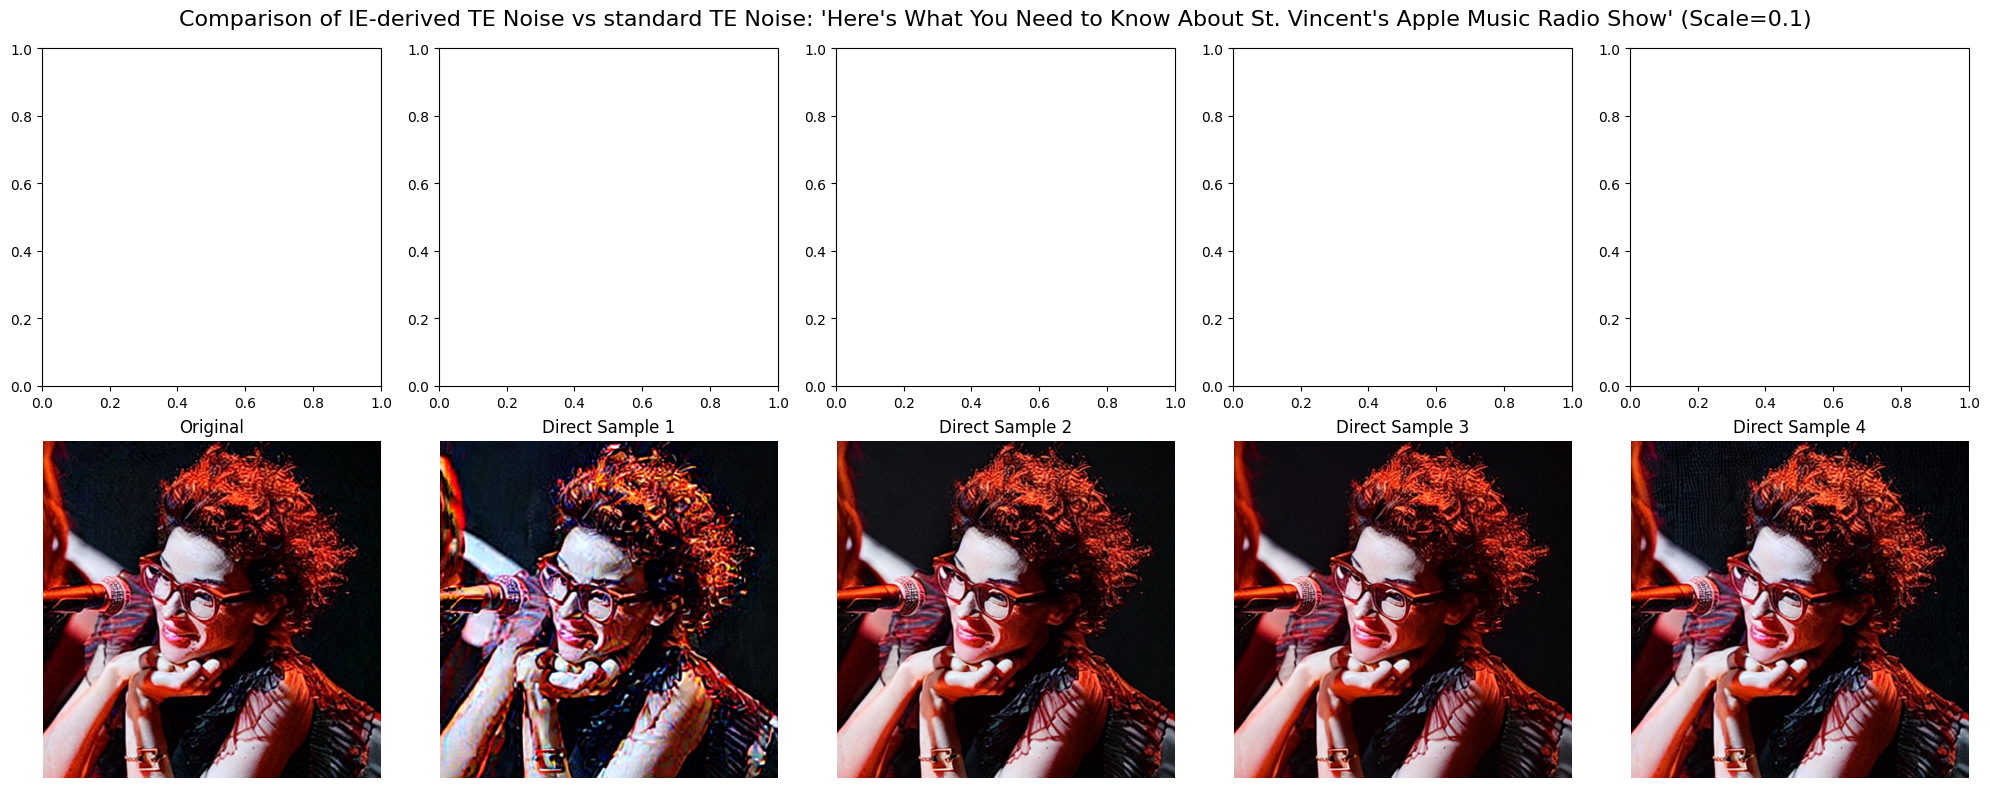

Visualizing for low-sensitivity prompt: Mothers influence on her young hippo
Generating original sample...
Generating samples with TE direct noise (scale=0.1)...


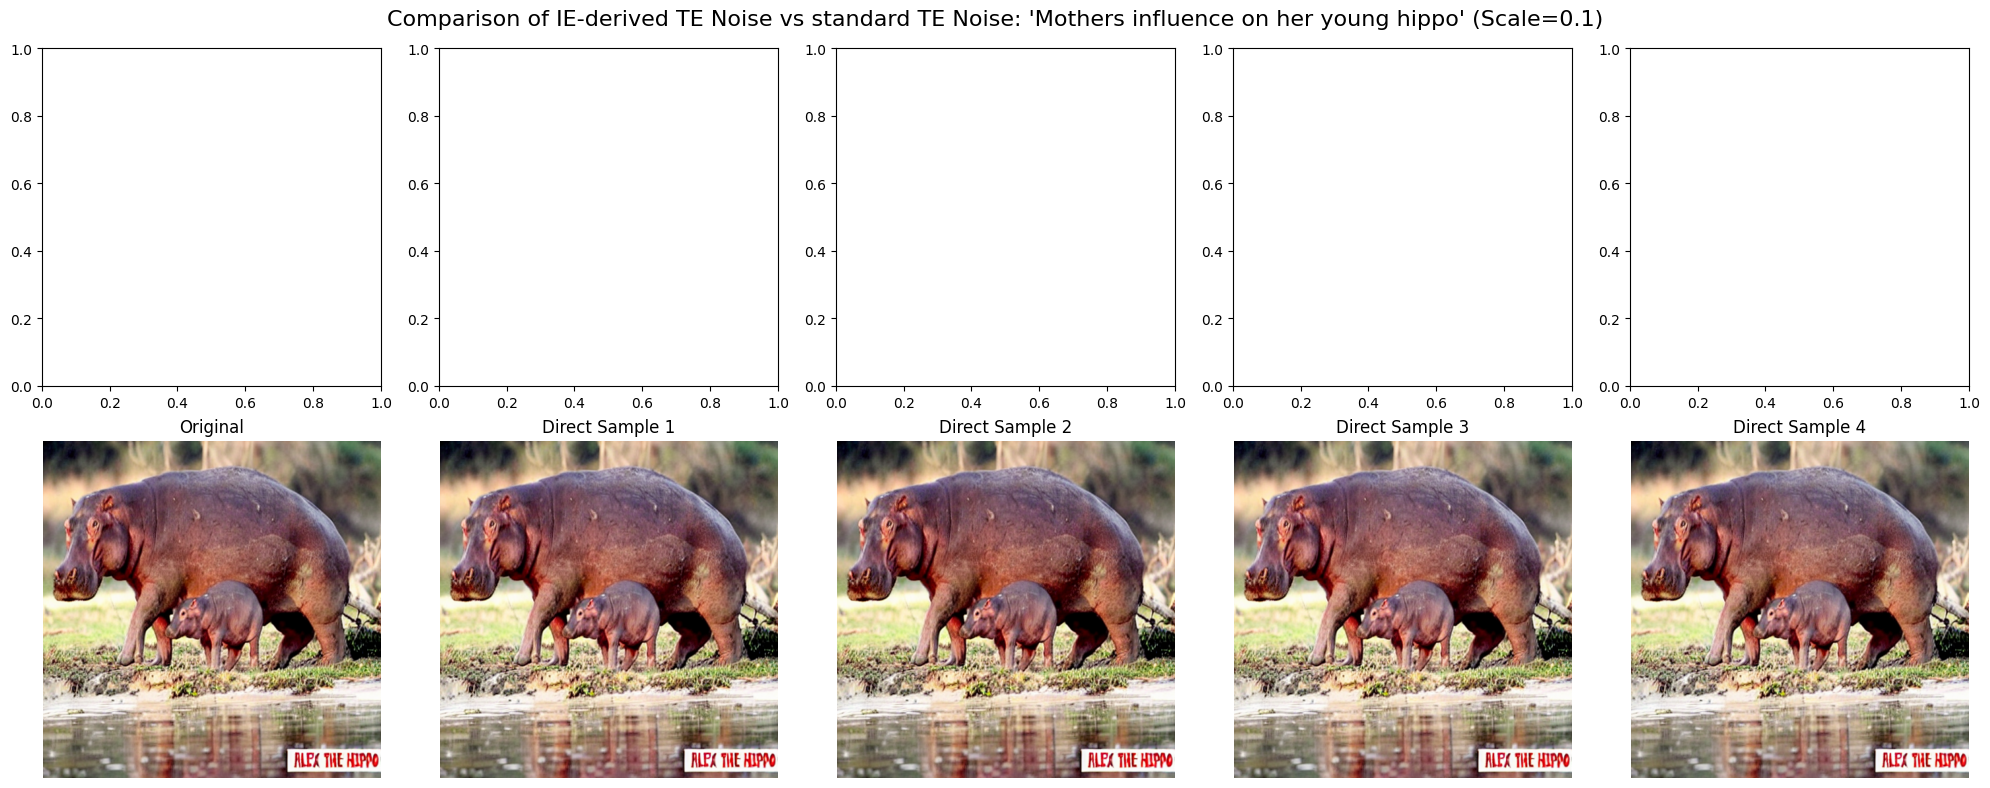

Visualizing for high-sensitivity prompt: Renegade RSS Laptop Backpack - View 91
Generating original sample...
Generating samples with TE direct noise (scale=0.1)...


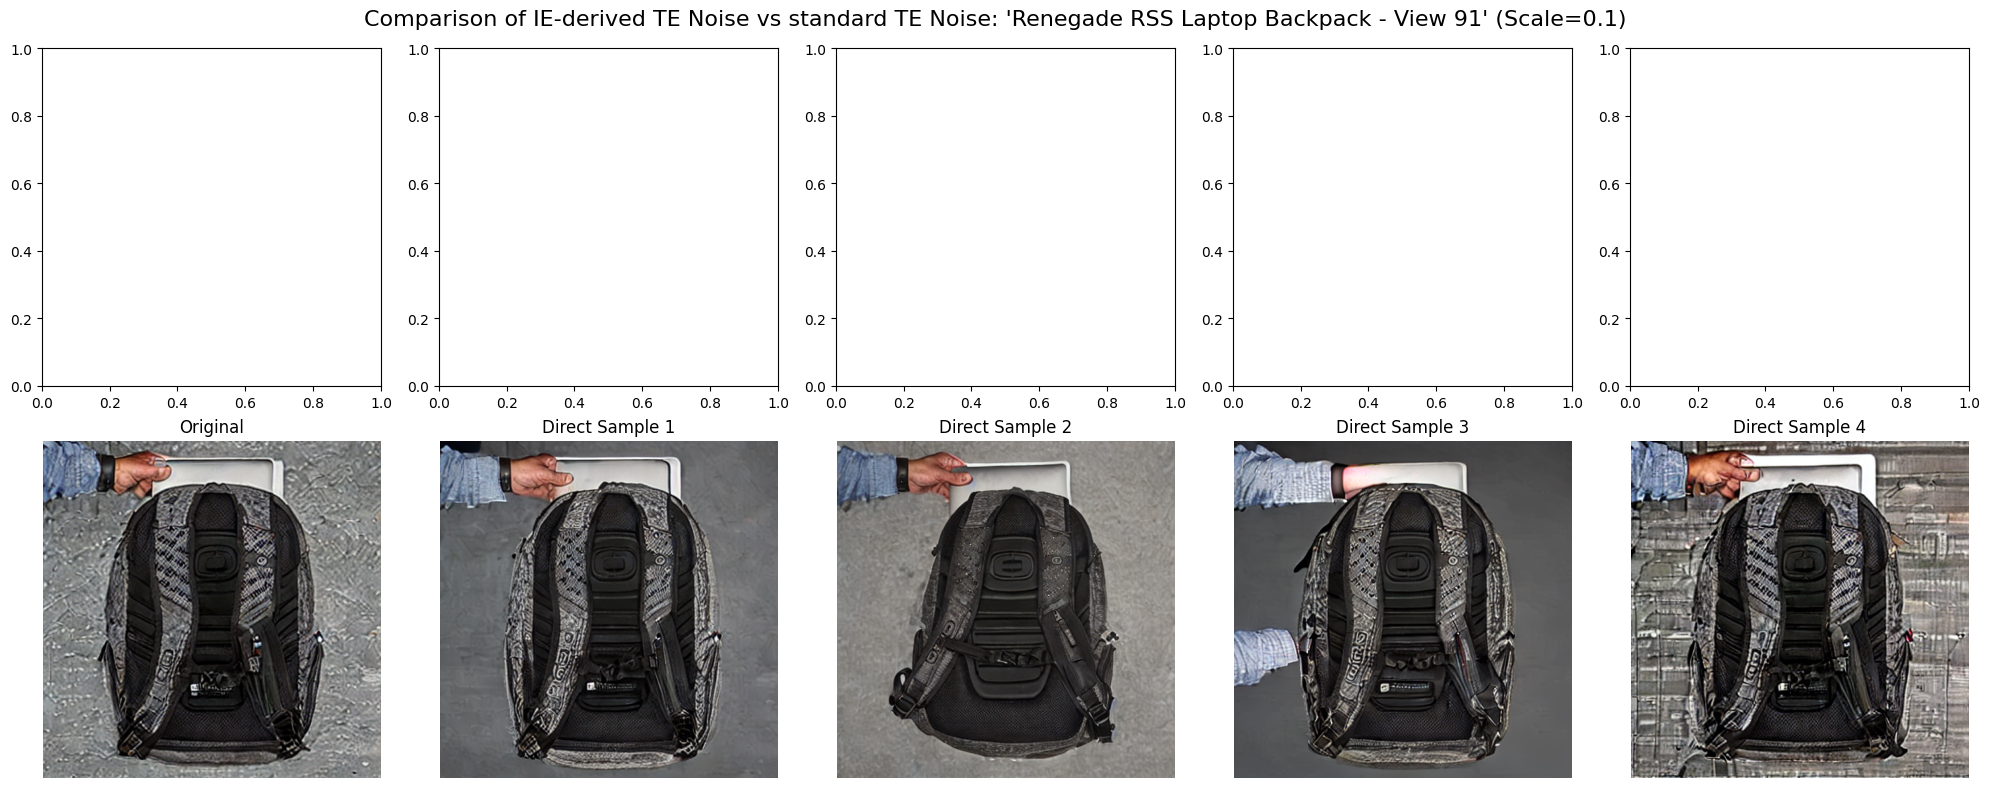

Visualizing for low-sensitivity prompt: Design Art Light in Dense Fall Forest with Fog Ultra Vibrant Landscape Oversized Circle Wall Art
Generating original sample...
Generating samples with TE direct noise (scale=0.1)...


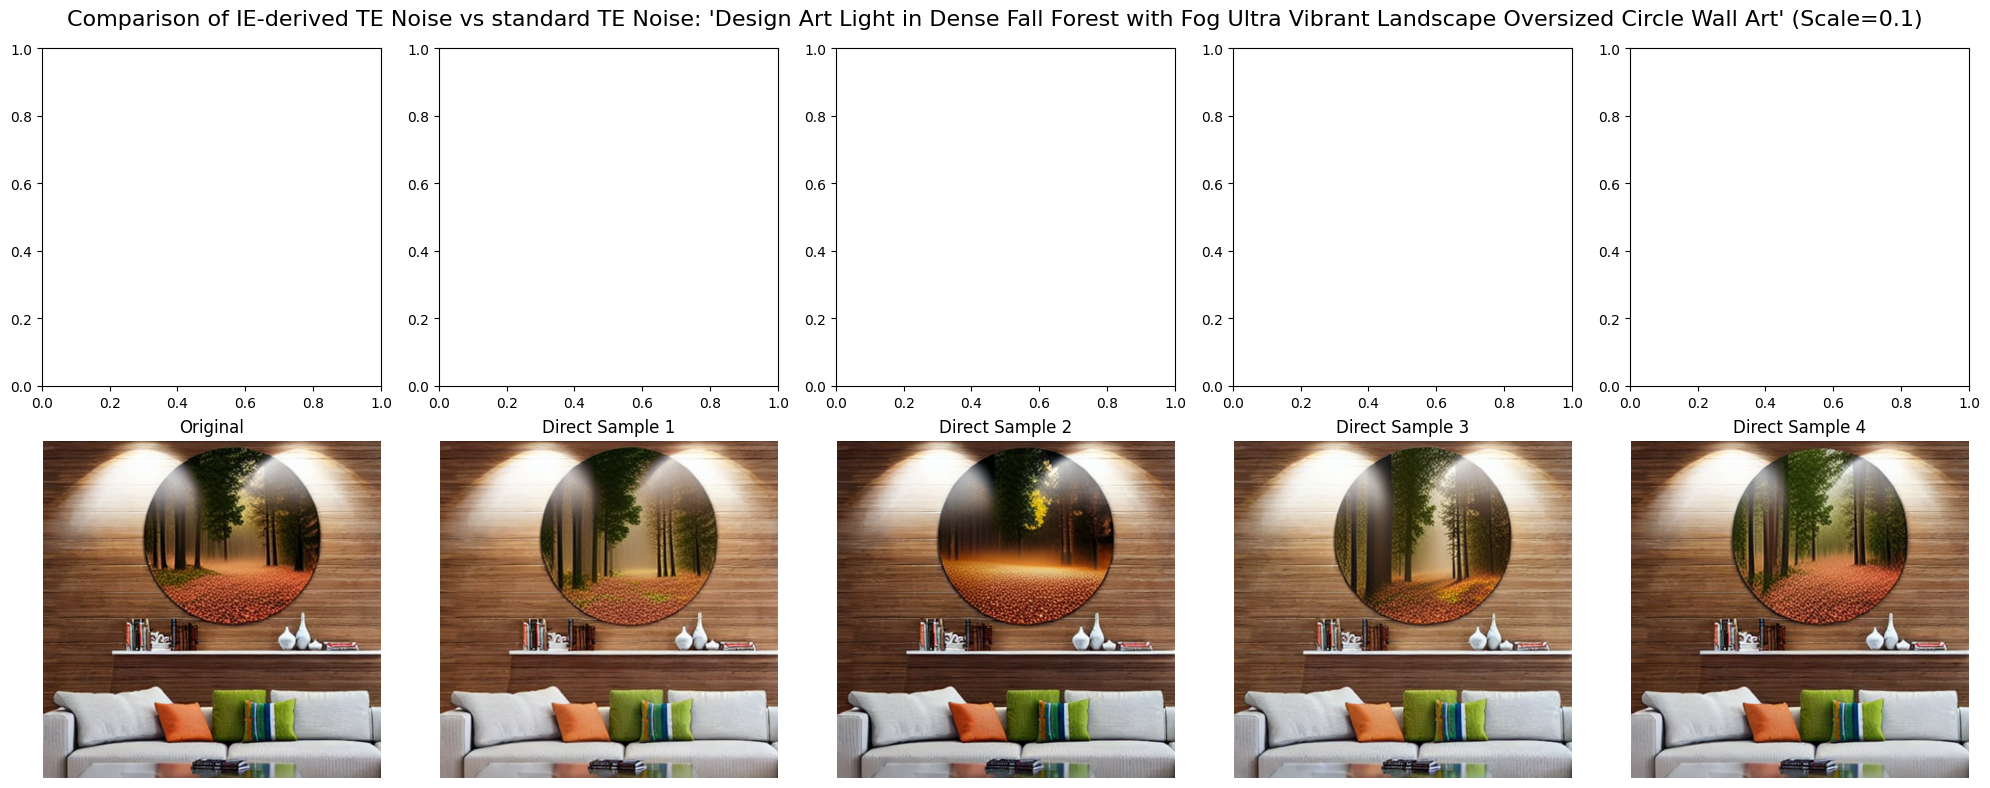

Visualizing for high-sensitivity prompt: Director Danny Boyle Is Headed To TV With FX Deal
Generating original sample...


Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Generating samples with TE direct noise (scale=0.1)...


Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


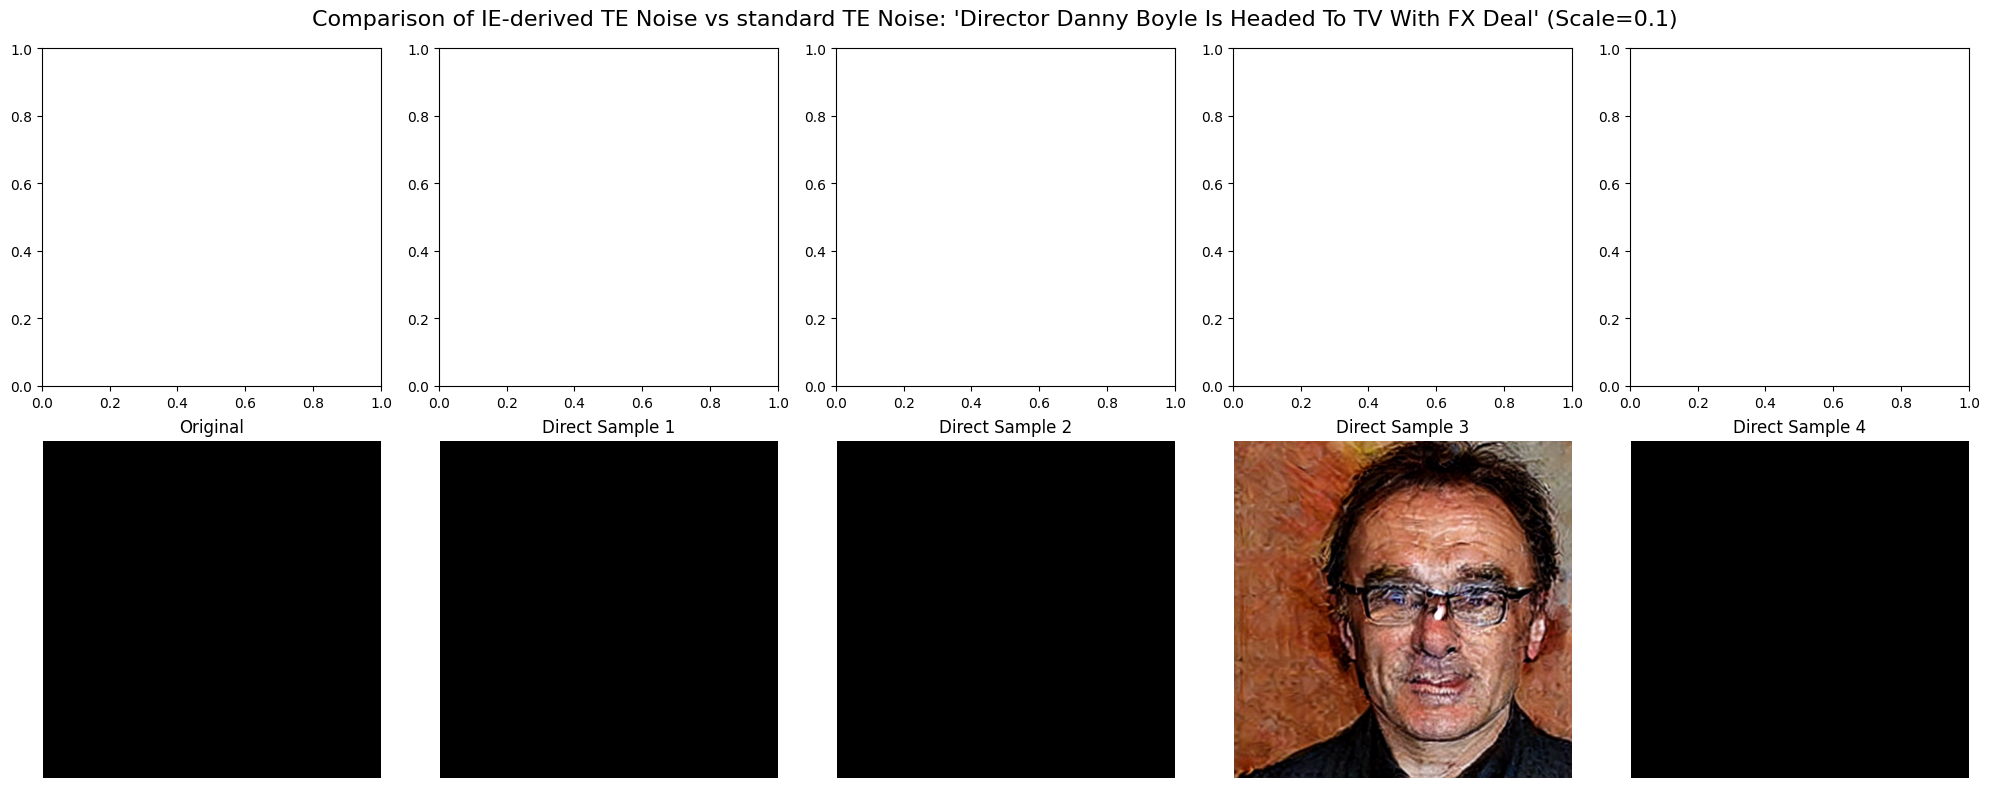

Visualizing for low-sensitivity prompt: The No Limits Business Woman Podcast
Generating original sample...
Generating samples with TE direct noise (scale=0.1)...


KeyboardInterrupt: 

In [ ]:
for idx in range(5):
    # Example usage with the prompt having the highest IE Jacobian Norm
    target_prompt = top5_ie.iloc[idx]['Prompt']
    print(f"Visualizing for high-sensitivity prompt: {target_prompt}")
    visualize_noise_injection(pipeline, target_prompt, noise_scale=0.1, n_samples=4)

    # Example usage with the prompt having the lowest IE Jacobian Norm
    target_prompt_low = bot5_ie.iloc[idx]['Prompt']
    print(f"Visualizing for low-sensitivity prompt: {target_prompt_low}")
    visualize_noise_injection(pipeline, target_prompt_low, noise_scale=0.1, n_samples=4)

In [ ]:
for idx in range(5):
    # Example usage with the prompt having the highest IE Jacobian Norm
    target_prompt = top5_te.iloc[idx]['Prompt']
    print(f"Visualizing for high-sensitivity prompt: {target_prompt}")
    visualize_noise_injection(pipeline, target_prompt, noise_scale=0.1, n_samples=4)

    # Example usage with the prompt having the lowest IE Jacobian Norm
    target_prompt_low = bot5_te.iloc[idx]['Prompt']
    print(f"Visualizing for low-sensitivity prompt: {target_prompt_low}")
    visualize_noise_injection(pipeline, target_prompt_low, noise_scale=0.1, n_samples=4)